In [2]:
%matplotlib inline

from collections import defaultdict as ddict, OrderedDict as odict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Descriptors import MolWt
from sklearn.ensemble import RandomForestRegressor
import sklearn
from rdkit.Chem.rdmolops import GetFormalCharge
import torch
import deepchem as dc
import copy
from sklearn.model_selection import train_test_split
import imp
import umap
import umap.plot
import sklearn.decomposition as decomp
from sklearn.preprocessing import StandardScaler

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation

RDKit WARNING: [22:27:41] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
from modules.data import data_maker
from modules.RNN import double_RNN
from modules.fit import Model, fit, predict, mae, rmse, load_exp
from modules.data import pka_scaler, double_loader, collate_double, sentence_dataset
from modules.myhyperopt import hyperopt_func
from modules.MPNN import double_MPNN

/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
data = pd.read_csv('data/full_pka_data.csv')
solute = data['Solute SMILES'].tolist()
solvent = data['Solvent SMILES'].tolist()
pka = data['pKa (avg)'].tolist()
data_size = len(solute)

sol_set = list(set(solute))
solv_set = list(set(solvent))

colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c',
           '#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#FAE318','#b15928']

In [6]:
indices = list(range(data_size))
CV_ids, holdout_ids, _, _ = train_test_split(indices, solvent, test_size=0.2, random_state=1, stratify=solvent)
datasets = data_maker(solute, solvent, pka)

In [7]:
DMPNN = Model(name='D-MPNN',
              model=double_MPNN(MP_depth=3, MP_hidden=256, NN_depth=2, NN_hidden=512, activation='ReLU', 
                                atom_messages=False, dropout=0, interaction=None, readout='sum'),
              lr=0.001,
              batch_size=64,
              model_type='torch',
              data_type='graphs')
DMPNN_att = Model(name='D-MPNN with attention',
              model=double_MPNN(MP_depth=4, MP_hidden=128, NN_depth=4, NN_hidden=64, activation='ELU', 
                                atom_messages=False, dropout=0, interaction='tanh', readout='mean'),
              lr=0.001,
              batch_size=64,
              model_type='torch',
              data_type='graphs')
MPNN = Model(name='MPNN',
             model=double_MPNN(MP_depth=3, MP_hidden=256, NN_depth=2, NN_hidden=512, activation='LeakyReLU', 
                                  atom_messages=True, dropout=0, interaction=None, readout='sum'),
             lr=0.001,
             batch_size=64,
             model_type='torch',
             data_type='graphs')
MPNN_att = Model(name='MPNN with attention',
             model=double_MPNN(MP_depth=2, MP_hidden=64, NN_depth=4, NN_hidden=512, activation='ReLU', 
                                  atom_messages=True, dropout=0, interaction='tanh', readout='max'),
             lr=0.001,
             batch_size=64,
             model_type='torch',
             data_type='graphs')
RNN = Model(name='RNN',
            model=double_RNN(NN_depth=3, NN_hidden=512, RNN_hidden=512, activation='ReLU', dropout=0.3,
                             features=300, interaction=None, readout='max'),
            lr=0.001,
            batch_size=32,
            model_type='torch',
            data_type='sentences')
RNN_att = Model(name='RNN with attention',
                model=double_RNN(NN_depth=1, NN_hidden=1024, RNN_hidden=512, activation='PReLU', dropout=0.1,
                                 features=300, interaction='exp', readout='max'),
                lr=0.001,
                batch_size=32,
                model_type='torch',
                data_type='sentences')
RF_desc = Model(name='Random forest with descriptors',
                model=RandomForestRegressor(bootstrap=True, max_depth=512, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=2048, n_jobs=-1),
                model_type='sklearn',
                data_type='descriptors')
RF_ECFP = Model(name='Random forest with ECFP',
                model=RandomForestRegressor(bootstrap=True, max_depth=512, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=2048, n_jobs=-1),
                model_type='sklearn',
                data_type='ECFP')
MLP_desc = Model(name='MLP with descriptors',
                 model=MLPRegressor(activation='logistic', batch_size=32, early_stopping=True, hidden_layer_sizes=(512, 256, 128), solver='adam'),
                 model_type='sklearn',
                 data_type='descriptors')
MLP_ECFP = Model(name='MLP with ECFP',
                 model=MLPRegressor(activation='relu', batch_size=16, early_stopping=True, hidden_layer_sizes=(256, 128, 64), solver='adam'),
                 model_type='sklearn',
                 data_type='ECFP')
XGB_desc = Model(name='XGBoost with descriptors',
                 model=XGBRegressor(colsample_bytree=0.7, eta=0.1, gamma=0, max_depth=8, min_child_weight=2, n_estimators=2048, n_jobs=-1, subsample=0.9),
                 model_type='sklearn',
                 data_type='descriptors')
XGB_ECFP = Model(name='XGBoost with ECFP',
                 model=XGBRegressor(colsample_bytree=0.6, eta=0.1, gamma=0, max_depth=8, min_child_weight=2, n_estimators=2048, n_jobs=-1, subsample=0.8),
                 model_type='sklearn',
                 data_type='ECFP')
#list of all models for testing
#models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RNN, RNN_att, RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, XGB_desc, XGB_ECFP]
models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, XGB_desc, XGB_ECFP]
DL_models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RNN, RNN_att]
#models = [RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, XGB_desc, XGB_ECFP]

In [8]:
#loading models
for m in models:
    data = datasets[m.data_type]
    load_exp(m, "Holdout test", data, CV_ids)

---
## Feature importance

MolLogP solv               0.047
MolMR solv                 0.041
qed solv                   0.040
LabuteASA solv             0.038
VSA_EState9 sol            0.031
EState_VSA9 solv           0.030
EState_VSA5 solv           0.030
SMR_VSA10 sol              0.029
MaxAbsPartialCharge solv   0.027
TPSA solv                  0.023
dtype: float64


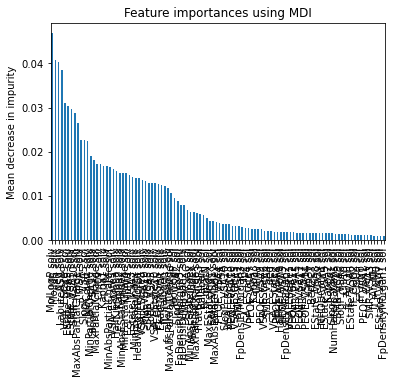

In [136]:
#feature importance for descriptor models
exp = RF_desc.experiments["Holdout test"]["model"]

featuriser = dc.feat.RDKitDescriptors()
sol = featuriser.featurize('CC')
features = featuriser.descriptors
sol_features = [feat+' sol' for feat in features]
solv_features = [feat+' solv' for feat in features]
feature_names = sol_features+solv_features

forest_importances = pd.Series(exp.feature_importances_, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)
tops = forest_importances[forest_importances > 0.001]

fig, ax = plt.subplots()
tops.plot.bar(ax=ax)
ax.set_ylabel("Mean decrease in impurity")
ax.set_xlabel("Descriptor")
print(forest_importances[0:10])

In [ ]:
print(forest_importances)

qed solv                0.222
MolWt solv              0.079
ExactMolWt solv         0.077
fr_COO2 sol             0.045
MinEStateIndex solv     0.033
fr_quatN sol            0.028
MaxPartialCharge solv   0.024
SMR_VSA10 sol           0.021
fr_Ar_NH sol            0.020
SlogP_VSA3 sol          0.020
dtype: float32


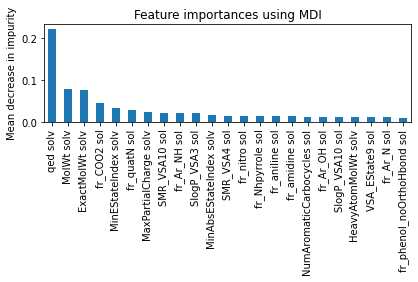

In [134]:
exp = XGB_desc.experiments["Holdout test"]["model"]

forest_importances = pd.Series(exp.feature_importances_, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)
tops = forest_importances[forest_importances > 0.01]

fig, ax = plt.subplots()
tops.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

print(forest_importances[0:10])

---
## Worst predictions

In [9]:
for m in models:
    print(m.name)
    ids = list(range(data_size))
    data = datasets[m.data_type]
    targets, outputs = predict(m, "Holdout test", data, ids)
    maes = [abs(targets[i]-outputs[i]) for i in ids]
    worst_ids = sorted(range(len(maes)), key=lambda i: maes[i])[-10:]
    for i in worst_ids:
        boool = i in holdout_ids
        print(boool, maes[i],solute[i],solvent[i],targets[i],outputs[i])

D-MPNN
True [5.717977] O=C(O)CS O 10.4 [4.6820226]
True [6.252181] CCCc1[nH+]c(C(C)(C)O)c(C(=O)OCc2oc(=O)oc2C)n1Cc1ccc(-c2ccccc2-c2nnn[n-]2)cc1 O 6.05 [-0.20218103]
False [6.270031] Cc1c([N+](=O)[O-])cc([N+](=O)[O-])cc1[N+](=O)[O-] CC#N 23.2 [16.92997]
False [6.333576] N#CC(C#N)c1cccc(C(F)(F)F)c1 C(CCl)Cl 49.0 [42.666424]
False [6.8149834] O=P(NP(=O)(C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F)(C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F C(CCl)Cl 33.5 [40.314983]
True [7.6807923] OCC(CO)(CO)CO O 14.1 [6.419208]
True [8.4742365] Nc1c(S(=O)(=O)F)cc(S(=O)(=O)F)cc1S(=O)(=O)F CC#N 19.66 [11.185763]
True [8.782203] O=S(=O)(O)O CC#N 7.4666667 [-1.3155357]
True [13.280411] O=S(=O)(O)O C(CCl)Cl 42.8 [29.519588]
False [15.758778] N#CC(C#N)c1c(F)c(F)cc(F)c1F C(CCl)Cl 23.75 [39.508778]
D-MPNN with attention
False [6.2604566] O=C1O[C@@H](C(O)=C1O)[C@H](CO)O O 11.57 [5.309543]
False [6.2604566] O=C1O[C@@H](C(O)=C1O)[C@H](CO)O O 11.57 [5.309543]
False [6.3131065] Cc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)c1C(F)(F)F CC#

---
## Attention layer analysis

---
## Learned feature latent space

In [119]:
#solute descriptors
featurizer = dc.feat.RDKitDescriptors()
sol_desc = featurizer.featurize(sol_set)
sol_desc = StandardScaler().fit_transform(sol_desc)

#solute mol2vec
sentence_sol = sentence_dataset(sol_set)
vec_sol = [torch.sum(sen, dim=0) for sen in sentence_sol]
vec_sol = np.array([t.detach().numpy() for t in vec_sol])
vec_sol = StandardScaler().fit_transform(vec_sol)

features = {'Descriptors':sol_desc, 'mol2vec':vec_sol}

In [18]:
fake_solv = ['O' for sol in sol_set]
fake_pka = [0 for sol in sol_set]
sol_datasets = data_maker(sol_set, fake_solv, fake_pka)

In [28]:
ids = list(range(len(sol_set)))
for m in DL_models:
    model = m.experiments["Holdout test"]["model"]
    data = sol_datasets[m.data_type]
    loader = double_loader(data, ids, batch_size=len(ids))
    for (sol,solv,targets) in loader:
        outputs = model.features(sol,solv)
        outputs = outputs[0].detach().numpy()
    features[m.name] = outputs

TypeError: 'int' object is not callable

In [102]:
#labels
#protonation sites
patt_lists = ddict(list)
acid_list = [('protonated amine','[N+,NH+,NH2+,NH3+,n+,nH+,nH2+,nH3+,NX3+,NX2+,N@H+,+]'),
             ('carboxylic acid','[CX3](=O)[OX2H1]'),
             ('phosphoric acid','[$(P(=[OX1])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)]),$([P+]([OX1-])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)])]'),
             ('phenol','[OX2H][cX3]:[c]'),
             ('hydroxyl alcohol','[#6][OX2H]'),
             ('thiol','[#16X2H]'),
             ('halogen','[HF,HCl,HBr,HI]')]

for name, smart in acid_list:
    patt = Chem.MolFromSmarts(smart)
    for smile in sol_set:
        mol = Chem.MolFromSmiles(smile)
        patt_lists[name].append(mol.HasSubstructMatch(patt))
    print(name+' matches: ',sum(patt_lists[name]))

class_list = []
for i in range(len(sol_set)):
    if patt_lists['protonated amine'][i] == True:
        class_list.append(0)
    elif patt_lists['carboxylic acid'][i] == True:
        class_list.append(1)
    elif patt_lists['phosphoric acid'][i] == True:
        class_list.append(2)
    elif patt_lists['phenol'][i] == True:
        class_list.append(3)
    elif patt_lists['hydroxyl alcohol'][i] == True:
        class_list.append(4)
    elif patt_lists['thiol'][i] == True:
        class_list.append(5)
    elif patt_lists['halogen'][i] == True:
        class_list.append(6)
    else:
        class_list.append(7)
class_list = np.array(class_list)
labels=class_list
classes=['protonated amine','carboxylic acid','phosphoric acid','phenol','hydroxyl alcohol','thiol','halogen','other']

protonated amine matches:  1717
carboxylic acid matches:  469
phosphoric acid matches:  12
phenol matches:  414
hydroxyl alcohol matches:  1091
thiol matches:  72
halogen matches:  3


Descriptors


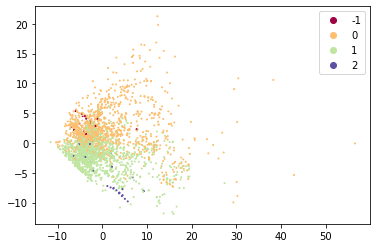

mol2vec


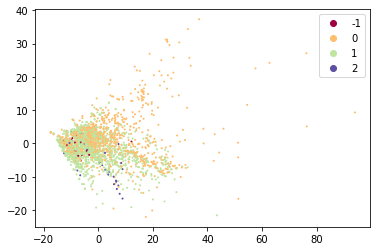

D-MPNN


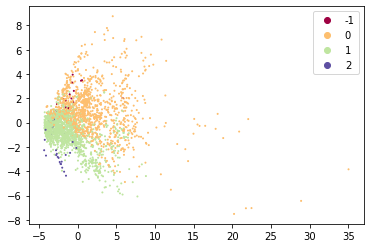

D-MPNN with attention


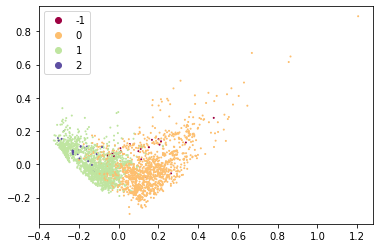

MPNN


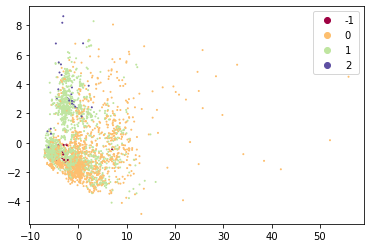

MPNN with attention


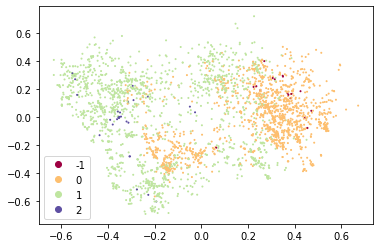

In [116]:
#PCA
PCA_func = decomp.PCA(n_components=2)

for name, d in features.items():
    print(name)
    sol_PCA = PCA_func.fit_transform(d)
    scatter = plt.scatter(sol_PCA[:,0], sol_PCA[:,1], s=1, c=labels, cmap='Spectral')
    plt.legend(handles=scatter.legend_elements()[0],labels=classes)
    plt.show()

Descriptors


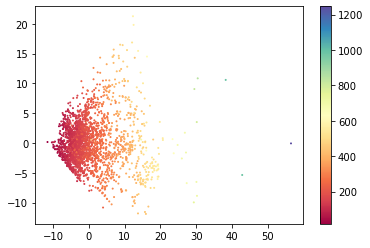

mol2vec


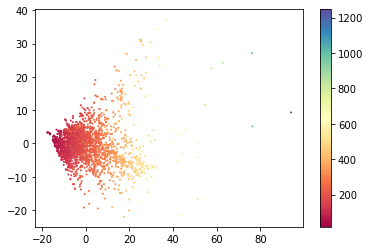

D-MPNN


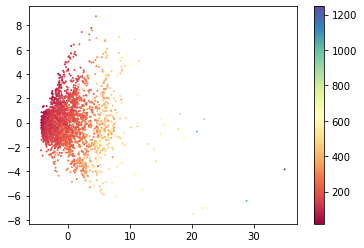

D-MPNN with attention


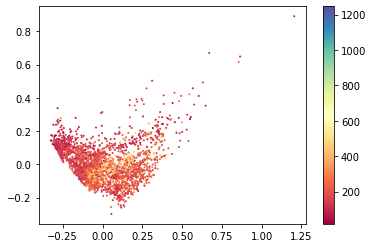

MPNN


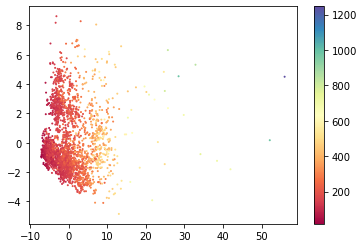

MPNN with attention


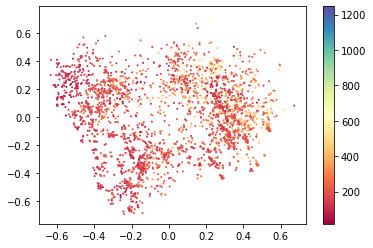

In [104]:
#mol weights
solute_masses = [MolWt(Chem.MolFromSmiles(mol)) for mol in sol_set]
labels=solute_masses

PCA_func = decomp.PCA(n_components=2)

for name, d in features.items():
    print(name)
    sol_PCA = PCA_func.fit_transform(d)
    scatter = plt.scatter(sol_PCA[:,0], sol_PCA[:,1], s=1, c=labels, cmap='Spectral')
    plt.colorbar()
    plt.show()

Descriptors


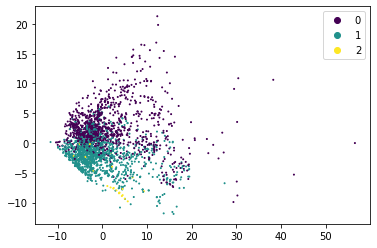

mol2vec


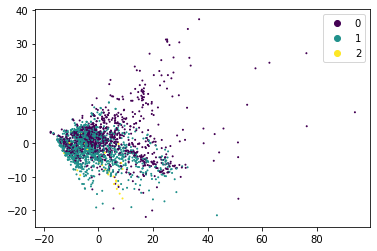

In [126]:
#charge
solute_charges = [GetFormalCharge(Chem.MolFromSmiles(mol)) for mol in sol_set]
labels=solute_charges
classes=[0,1,2]

PCA_func = decomp.PCA(n_components=2)

for name, d in features.items():
    print(name)
    sol_PCA = PCA_func.fit_transform(d)
    scatter = plt.scatter(sol_PCA[:,0], sol_PCA[:,1], s=1, c=labels, cmap='viridis')
    plt.legend(handles=scatter.legend_elements()[0],labels=classes)
    plt.show()

Descriptors


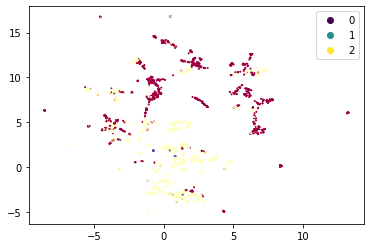

mol2vec


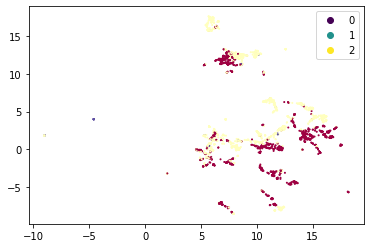

In [128]:
#UMAP2
for name, d in features.items():
    print(name)
    d_map = umap.UMAP().fit_transform(d)
    #umap.plot.points(mapper, labels=np.array(labels))
    plt.scatter(d_map[:,0], d_map[:,1], s=1, c=labels, cmap='Spectral')
    plt.legend(handles=scatter.legend_elements()[0],labels=classes)
    plt.show()

Descriptors


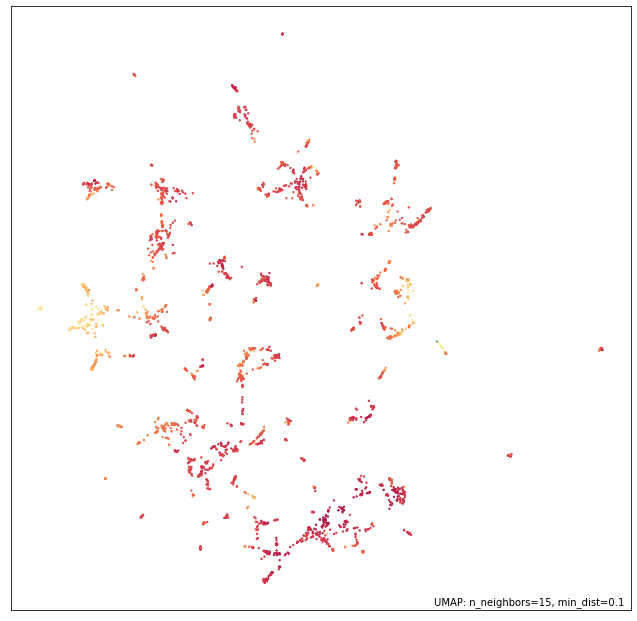

mol2vec


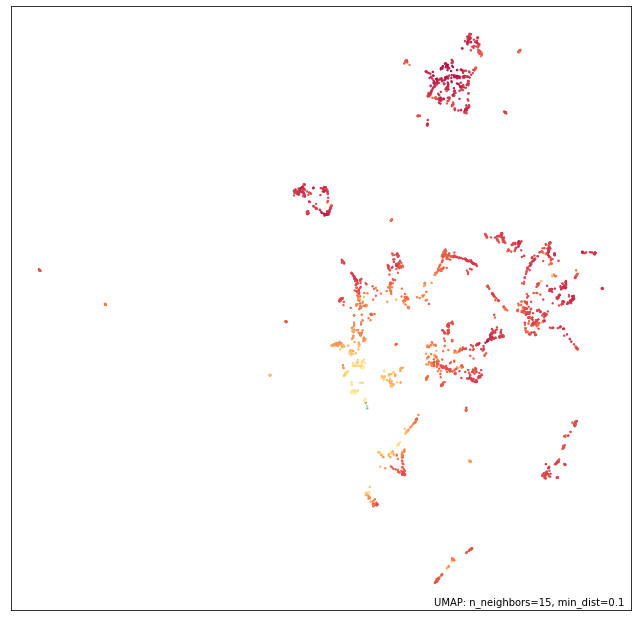

D-MPNN


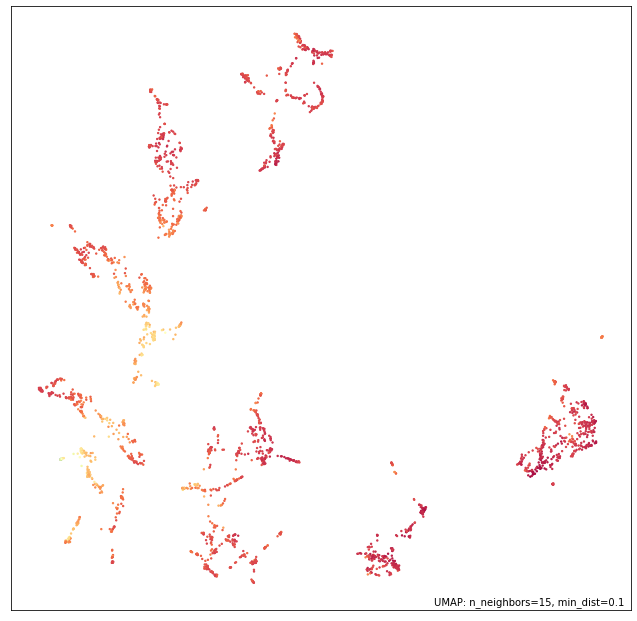

D-MPNN with attention


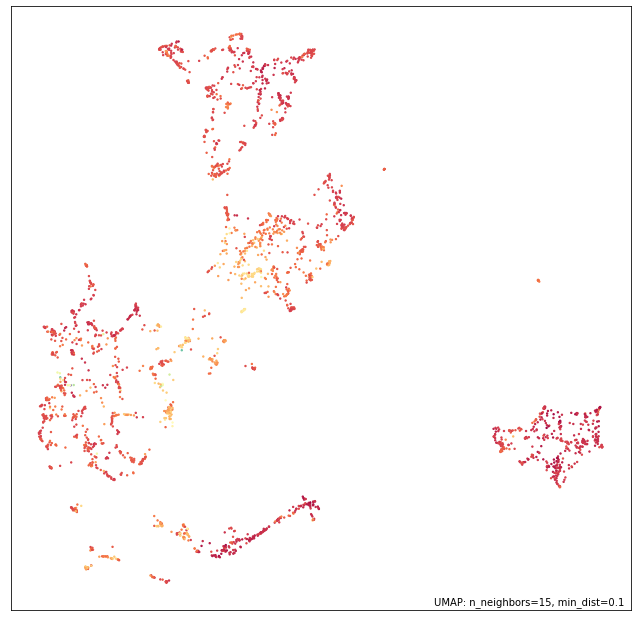

MPNN


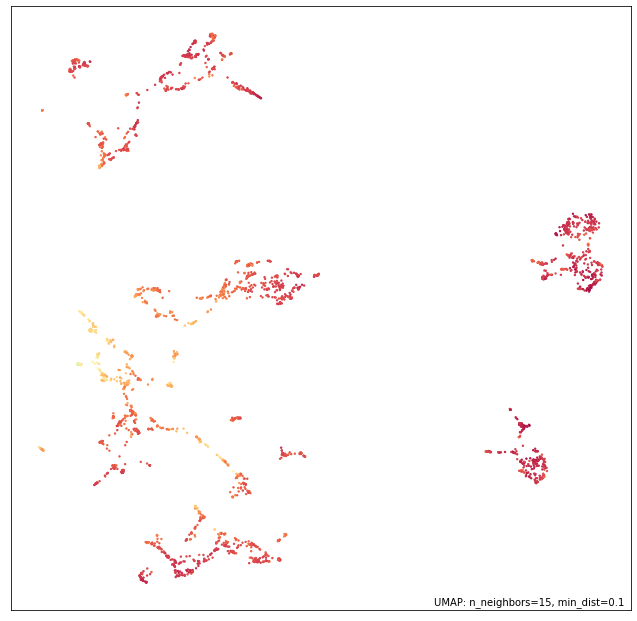

MPNN with attention


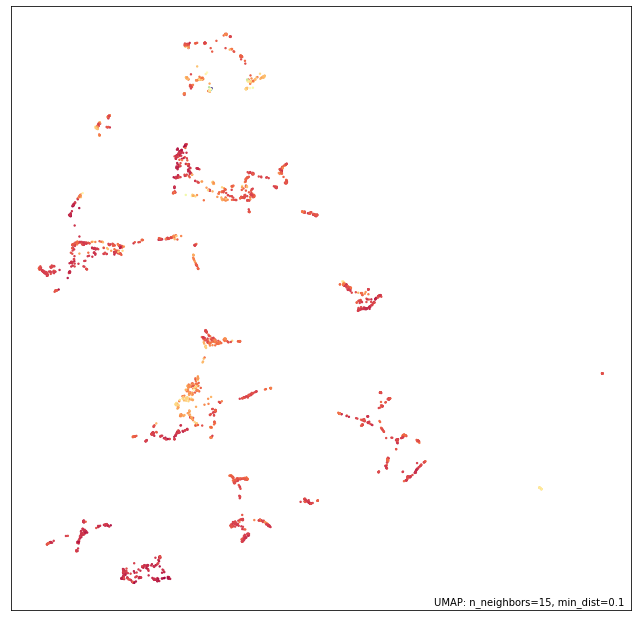

In [93]:
#UMAP
for name, d in features.items():
    print(name)
    mapper = umap.UMAP().fit(d)
    #umap.plot.points(mapper, labels=np.array(labels))
    umap.plot.points(mapper, values=np.array(labels), cmap='Spectral')
    plt.show()